In [1]:
import timm
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import fastcore.all as fc
import numpy as np
import torchvision

In [2]:
import matplotlib.pyplot as plt

In [3]:
print(timm.list_models('*vgg*'))

['repvgg_a0', 'repvgg_a1', 'repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'repvgg_d2se', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [4]:
vgg16 = timm.create_model('vgg16', pretrained=True)

In [5]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"
anime_url = 'https://cdn.donmai.us/sample/90/46/__original_drawn_by_aaaa_quad_a__sample-9046147a2e9255716919f28e0f696435.jpg'
cat_url = 'https://hips.hearstapps.com/hmg-prod/images/beautiful-smooth-haired-red-cat-lies-on-the-sofa-royalty-free-image-1678488026.jpg?crop=1xw:0.84415xh;center,top'

## Download image

In [6]:
def download_image(url):
    img = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(torch.tensor(list(img), dtype=torch.uint8)).float()/255.

In [7]:
img = download_image(face_url)

# Show image

In [8]:
def show_image(img, ax=None, figsize = None, title=None, noFrame = True, **kwargs):
    #check if image is a tensor
    for attr in [ 'detach', 'cpu', 'detach']:
        #if has cpu, detach or cpu methods we detach
        if hasattr(img, attr):
            img = img.detach().cpu()
        #if the channels are first we check it is less than 5 and premute if it is
        if len(img.shape)==3 and img.shape[0] <5:
            img = img.permute(1,2,0)
    #TODO: add numpy if imafge isnt numpy weird error 

    if ax is None:
        _,ax = plt.subplots(figsize=figsize)
    ax.imshow(img, **kwargs)
    if title is not None:
        ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

    if noFrame:
        ax.axis('off')
    return ax
    

<Axes: >

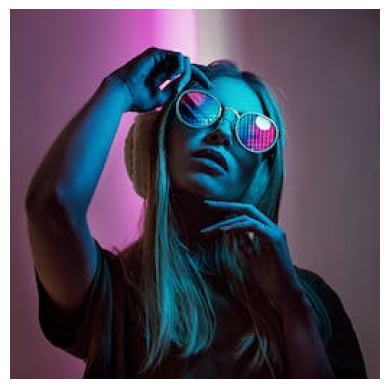

In [9]:
show_image(img)

# Hooks

In [10]:
from functools import  partial

In [11]:
class Hook:
    def __init__(self, m, func):
        self.hook = m.register_forward_hook(partial(func, self))
    def remove(self):
        self.hook.remove()
    def __del__(self):
        self.remove()

In [12]:
def hook_visualisation(hook, mod, inp, out):
    if not hasattr(hook, 'visualisation'): 
        hook.visualisation = []
    hook.visualisation.append(out.detach().cpu())

In [13]:
hooks = [Hook(m, hook_visualisation) for m in vgg16.children()]

# Create a context Manager

In [14]:
class Hooks(list):
    def __init__(self, model, function):
        super().__init__([Hook(m,function) for i, m in enumerate(model)])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(self, i)
    def remove(self):
        #remove all hooks to remove memory
        for h in self:
            h.remove()

In [15]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std =torch.tensor([0.229, 0.224, 0.225])

In [16]:
class HookCapture:
    def __init__(self, model, function, layers = None, transforms = None):
        self.transforms = transforms
        if layers is None:
            mods = [m for i,m in enumerate(model.children())]
        else:
            mods = [m for i,m in enumerate(model.children()) if i in layers]
        self.hooks = Hooks(mods, function)

    def predict(self, model, img):
        model.eval()
        for t in self.transforms: img = t(img)
        output = model(img[None,...])
        self.hooks.remove()
        return output

    def visualise_feature(self, img, layer=0, idx=0, alpha = 0.7):
        if layer > len(self.hooks):
            print('layer is not in the feature visualisations')
        ax = show_image(img)
        resize_func = torchvision.transforms.Resize(img.shape[1:])
        hooks = self.hooks[layer]
        activations = hooks.visualisation[0][0][idx]
        print(activations.shape, img.shape[1:])
        activations = resize_func(activations[None,...]).squeeze() #have to add batch size to use 
        
        ax.imshow(activations, alpha=alpha)

        return ax

In [17]:
a = HookCapture(vgg16, hook_visualisation,  transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std)])

In [18]:
vgg16.children

<bound method Module.children of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2

In [19]:
output = a.predict(vgg16, img)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [20]:
a.hooks

torch.Size([8, 8]) torch.Size([256, 256])


/Users/davidgillespie/opt/anaconda3/envs/fastai/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<Axes: >

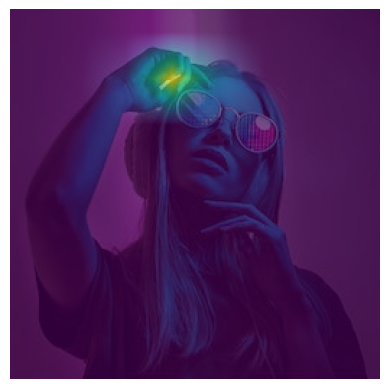

In [21]:
a.visualise_feature(img, 0, 100)

In [22]:
output = F.softmax(output, dim=-1)
torch.argmax(output)

tensor(643)

In [23]:
## Class activation Maps

In [24]:
import json
class_idx = json.load(open("/Users/davidgillespie/Downloads/imagenet_class_index.json", 'rb'))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
label2idx = {v:k for k,v in enumerate( idx2label)}

In [25]:
idx2label[100], label2idx['black_swan']

('black_swan', 100)

# Resnet

In [26]:
print(timm.list_models('*resnet*'))

['cspresnet50', 'cspresnet50d', 'cspresnet50w', 'eca_resnet33ts', 'ecaresnet26t', 'ecaresnet50d', 'ecaresnet50d_pruned', 'ecaresnet50t', 'ecaresnet101d', 'ecaresnet101d_pruned', 'ecaresnet200d', 'ecaresnet269d', 'ecaresnetlight', 'gcresnet33ts', 'gcresnet50t', 'inception_resnet_v2', 'lambda_resnet26rpt_256', 'lambda_resnet26t', 'lambda_resnet50ts', 'legacy_seresnet18', 'legacy_seresnet34', 'legacy_seresnet50', 'legacy_seresnet101', 'legacy_seresnet152', 'nf_ecaresnet26', 'nf_ecaresnet50', 'nf_ecaresnet101', 'nf_resnet26', 'nf_resnet50', 'nf_resnet101', 'nf_seresnet26', 'nf_seresnet50', 'nf_seresnet101', 'resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_gn', 'resnet50c', 'resnet50d', 'resnet50s', 'resnet50t', 'resnet51q', 'resnet61q', 'resnet101', 'resnet101c', 'resnet101d', 'resnet101s', 'resnet152', 'resnet152c', 'resnet152d', 'resnet152s', 'resnet200', 'resnet200d', 'resn

In [27]:
resnet = timm.create_model('resnet34', pretrained=True)

In [28]:
# a = HookCapture(resnet, hook_visualisation, transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std), torchvision.transforms.Resize((244,244))])
a = HookCapture(resnet, hook_visualisation, transforms=[torchvision.transforms.Normalize(imagenet_mean, imagenet_std)])

In [29]:
output = a.predict(resnet, img)

torch.Size([128, 128]) torch.Size([256, 256])


<Axes: >

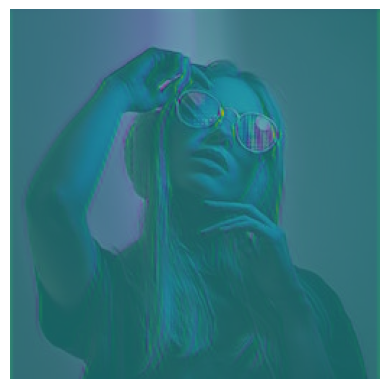

In [30]:
a.visualise_feature(img)

In [31]:
act = a.hooks[-3].visualisation[0][0]; act.shape

torch.Size([512, 8, 8])

In [32]:
cam_map = torch.einsum('bk,kij->bij', resnet.fc.weight, act)

In [33]:
torch.argmax(F.softmax(output, dim=-1)).numpy()

array(643)

In [34]:
idx2label[torch.argmax(F.softmax(output, dim=-1))]

'mask'

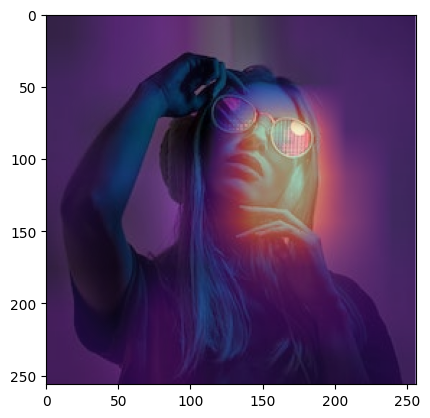

In [35]:
plt.imshow(img.permute(1,2,0))
plt.imshow(cam_map[torch.argmax(F.softmax(output, dim=-1))].detach().numpy(), alpha=0.6, extent=(0,img.shape[2], img.shape[1],0),
              interpolation='bilinear', cmap='magma');